In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, GRU, SimpleRNN, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [4]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [5]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


# Trying the Wrong approach : Using only 1 value(closing price) & doing 1 step prediction to fool ourselves

In [6]:
series = df['close'].values

In [7]:
series.shape

(1259,)

In [8]:
series = series.reshape(-1,1)

In [9]:
series.shape

(1259, 1)

In [10]:
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.fit_transform(series)

In [11]:
T = 10
D = 1
X = []
Y = []

for i in range(len(series) - T):
    x = series[i:i+T]
    X.append(x)
    
    y = series[i+T]
    Y.append(y)
    

In [12]:
N = len(X)
N

1249

In [13]:
X = np.array(X).reshape(-1,T,D)
Y = np.array(Y)

In [14]:
i = Input(shape=(X[0].shape))
x = LSTM(10)(i)
x = Dense(1)(x)

model = Model(i,x)

model.compile(loss = 'mse' , optimizer = Adam(lr=0.1))

r = model.fit(X[:N//2] , Y[:N//2] , epochs = 80 , validation_data=(X[N//2:],Y[N//2:]))

Epoch 1/80
20/20 [==============================] - 1s 32ms/step - loss: 0.1422 - val_loss: 0.0248
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0265
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0044 - val_loss: 0.0202
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0201
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0169
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0186
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0160
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0139
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0156
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0170
Epoch 11/80
20/20 

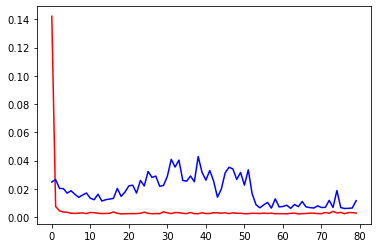

In [15]:
plt.plot(r.history['loss'] , label = 'loss' , color = 'red')
plt.plot(r.history['val_loss'] , label = 'Val loss' , color = 'blue')

In [16]:
model.predict(X[0].reshape(-1,T,D))[0,0]

-2.0257776

In [17]:
# Single step prediction on test data

i = N//2

pred_vals = []

while len(pred_vals) < len(Y[N//2:]):
    v = model.predict(X[i].reshape(-1,T,D))[0,0]
    pred_vals.append(v)
    i+=1


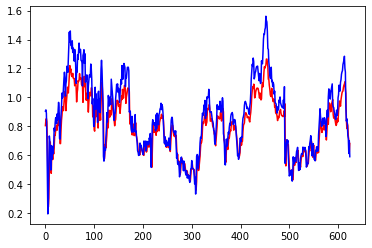

In [18]:
plt.plot(pred_vals, label = 'pred' , color = 'red')
plt.plot(Y[N//2:], label = 'orig' , color = 'blue')

In [19]:
# Multi step forecast

i = X[N//2]

pred_vals = []

while len(pred_vals) < len(Y[N//2:]):
    v = model.predict(i.reshape(-1,T,D))[0,0]
    pred_vals.append(v)
    
    i = np.roll(i,-1)
    i[-1] = v
    


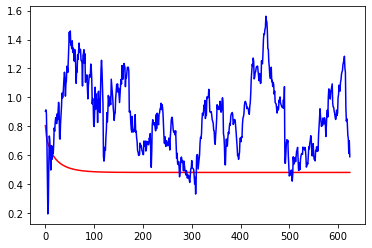

In [20]:
plt.plot(pred_vals , label = 'preds' , color = 'red')
plt.plot(Y[N//2:] , label = 'orig' , color = 'blue')

### This messed up, right?

### What we really want to predict is the return , i.e. ,  (V_final - V_initial)/V_initial

In [21]:
df['PrevClose'] = df['close'].shift(1) # move everything up 1 as we need data from consec rows inthe same column to subtract

In [22]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

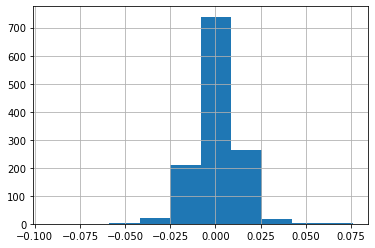

In [23]:
df['Return'].hist()

In [24]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [25]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [26]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 25ms/step - loss: 0.9961 - val_loss: 1.1356
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9856 - val_loss: 1.1292
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9866 - val_loss: 1.1376
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9851 - val_loss: 1.1370
Epoch 5/80
20/20 [==============================] - 0s 5ms/step - loss: 0.9856 - val_loss: 1.1485
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9833 - val_loss: 1.1341
Epoch 7/80
20/20 [==============================] - 0s 5ms/step - loss: 0.9839 - val_loss: 1.1410
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9827 - val_loss: 1.1393
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9821 - val_loss: 1.1402
Epoch 10/80
20/20 [==============================] - 0s 5ms/step - loss: 0.9787 - val_loss: 1.1582
Epoch 11/80
20/20 

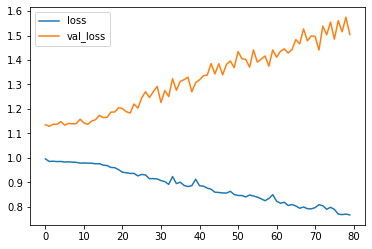

In [27]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


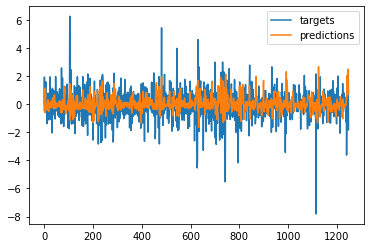

In [28]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

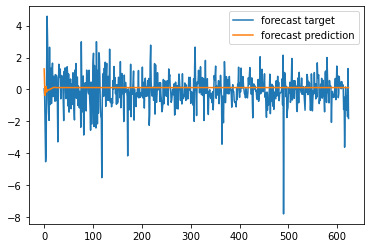

In [29]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [ ]:
## It still messed up! Though we can improve by adding multiple layers

# Method 3
## Now we include all the features!

Regression is harder than classification! So, instead of predicting value, we can predict if it wll go up or down

In [32]:
list(df.columns)

['date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'Name',
 'PrevClose',
 'Return']

In [33]:
input_data = df[['open' , 'high' , 'low' , 'close' , 'volume']].values


In [35]:
input_data.shape

(1259, 5)

In [34]:
targets = df['Return'].values

In [36]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [37]:
Ntrain = len(input_data) * 2//3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data = scaler.transform(input_data)

In [38]:
X_train = np.zeros((Ntrain,T,D))
Y_train = np.zeros(Ntrain)

In [39]:
for n in range(Ntrain):
    X_train[n , : , :] = input_data[n:n+T]
    Y_train[n] = (targets[n+T] > 0 )

In [44]:
X_test = np.zeros((N - Ntrain,T,D))
Y_test = np.zeros(N - Ntrain)

In [46]:
for u in range(N-Ntrain):
    n= u + Ntrain
    X_test[u , : , :] = input_data[n : n+T]
    Y_test[u] = (targets[n+T] >0)

In [58]:
i = Input(shape=(X_train[0].shape))
x = LSTM(32 , return_sequences = True)(i)
x = LSTM(32 , return_sequences = True)(x)
x = LSTM(32)(x)
x = Dense(1 , activation = 'sigmoid')(x)

model = Model(i,x)

model.compile(optimizer = Adam(lr = 0.001) , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [59]:
r = model.fit(X_train , Y_train ,  batch_size = 32 ,epochs = 300 , validation_data = (X_test,Y_test))

Epoch 1/300
27/27 [==============================] - 2s 56ms/step - loss: 0.6942 - accuracy: 0.4732 - val_loss: 0.6942 - val_accuracy: 0.4854
Epoch 2/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6922 - accuracy: 0.5244 - val_loss: 0.6941 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6929 - accuracy: 0.5232 - val_loss: 0.6935 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6928 - accuracy: 0.5244 - val_loss: 0.6957 - val_accuracy: 0.4854
Epoch 5/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6920 - accuracy: 0.5244 - val_loss: 0.6949 - val_accuracy: 0.4854
Epoch 6/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6923 - accuracy: 0.5244 - val_loss: 0.6937 - val_accuracy: 0.4854
Epoch 7/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6917 - accuracy: 0.5244 - val_loss: 0.6942 - val_accuracy: 0.4854
Epoch 

27/27 [==============================] - 0s 12ms/step - loss: 0.6728 - accuracy: 0.5733 - val_loss: 0.6968 - val_accuracy: 0.5098
Epoch 59/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6682 - accuracy: 0.5769 - val_loss: 0.6985 - val_accuracy: 0.5073
Epoch 60/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6668 - accuracy: 0.5936 - val_loss: 0.6954 - val_accuracy: 0.5146
Epoch 61/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6692 - accuracy: 0.5995 - val_loss: 0.6949 - val_accuracy: 0.5073
Epoch 62/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6653 - accuracy: 0.5876 - val_loss: 0.6989 - val_accuracy: 0.5268
Epoch 63/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6686 - accuracy: 0.5793 - val_loss: 0.7070 - val_accuracy: 0.4951
Epoch 64/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6691 - accuracy: 0.5816 - val_loss: 0.7002 - val_accuracy: 0.4927
Epoch 65/300

27/27 [==============================] - 0s 12ms/step - loss: 0.5620 - accuracy: 0.6687 - val_loss: 0.8099 - val_accuracy: 0.4780
Epoch 116/300
27/27 [==============================] - 0s 11ms/step - loss: 0.5690 - accuracy: 0.6734 - val_loss: 0.8279 - val_accuracy: 0.4683
Epoch 117/300
27/27 [==============================] - 0s 12ms/step - loss: 0.5575 - accuracy: 0.6698 - val_loss: 0.8455 - val_accuracy: 0.4732
Epoch 118/300
27/27 [==============================] - 0s 12ms/step - loss: 0.5559 - accuracy: 0.6651 - val_loss: 0.8053 - val_accuracy: 0.4951
Epoch 119/300
27/27 [==============================] - 0s 12ms/step - loss: 0.5483 - accuracy: 0.6782 - val_loss: 0.8417 - val_accuracy: 0.4854
Epoch 120/300
27/27 [==============================] - 0s 12ms/step - loss: 0.5411 - accuracy: 0.6937 - val_loss: 0.8379 - val_accuracy: 0.4732
Epoch 121/300
27/27 [==============================] - 0s 12ms/step - loss: 0.5351 - accuracy: 0.6770 - val_loss: 0.8691 - val_accuracy: 0.4927
Epoch 

Epoch 172/300
27/27 [==============================] - 0s 12ms/step - loss: 0.3687 - accuracy: 0.8117 - val_loss: 1.4358 - val_accuracy: 0.4951
Epoch 173/300
27/27 [==============================] - 0s 12ms/step - loss: 0.3374 - accuracy: 0.8331 - val_loss: 1.4554 - val_accuracy: 0.5073
Epoch 174/300
27/27 [==============================] - 0s 12ms/step - loss: 0.3119 - accuracy: 0.8546 - val_loss: 1.4625 - val_accuracy: 0.5073
Epoch 175/300
27/27 [==============================] - 0s 12ms/step - loss: 0.3132 - accuracy: 0.8522 - val_loss: 1.5580 - val_accuracy: 0.4805
Epoch 176/300
27/27 [==============================] - 0s 12ms/step - loss: 0.2998 - accuracy: 0.8605 - val_loss: 1.5658 - val_accuracy: 0.5024
Epoch 177/300
27/27 [==============================] - 0s 12ms/step - loss: 0.3036 - accuracy: 0.8534 - val_loss: 1.5878 - val_accuracy: 0.4756
Epoch 178/300
27/27 [==============================] - 0s 12ms/step - loss: 0.3115 - accuracy: 0.8474 - val_loss: 1.6034 - val_accuracy:

27/27 [==============================] - 0s 12ms/step - loss: 0.2004 - accuracy: 0.9261 - val_loss: 2.1601 - val_accuracy: 0.4902
Epoch 229/300
27/27 [==============================] - 0s 12ms/step - loss: 0.1819 - accuracy: 0.9237 - val_loss: 2.0748 - val_accuracy: 0.4756
Epoch 230/300
27/27 [==============================] - 0s 12ms/step - loss: 0.1430 - accuracy: 0.9428 - val_loss: 2.0969 - val_accuracy: 0.5122
Epoch 231/300
27/27 [==============================] - 0s 12ms/step - loss: 0.1328 - accuracy: 0.9487 - val_loss: 2.2478 - val_accuracy: 0.4951
Epoch 232/300
27/27 [==============================] - 0s 12ms/step - loss: 0.1581 - accuracy: 0.9321 - val_loss: 2.2491 - val_accuracy: 0.4902
Epoch 233/300
27/27 [==============================] - 0s 12ms/step - loss: 0.1375 - accuracy: 0.9487 - val_loss: 2.2348 - val_accuracy: 0.4976
Epoch 234/300
27/27 [==============================] - 0s 12ms/step - loss: 0.1276 - accuracy: 0.9547 - val_loss: 2.3045 - val_accuracy: 0.4878
Epoch 

Epoch 285/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0358 - accuracy: 0.9881 - val_loss: 2.6817 - val_accuracy: 0.4854
Epoch 286/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0377 - accuracy: 0.9917 - val_loss: 2.7595 - val_accuracy: 0.4976
Epoch 287/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0311 - accuracy: 0.9940 - val_loss: 2.7370 - val_accuracy: 0.5000
Epoch 288/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0263 - accuracy: 0.9964 - val_loss: 2.6670 - val_accuracy: 0.4951
Epoch 289/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0312 - accuracy: 0.9940 - val_loss: 2.7324 - val_accuracy: 0.4927
Epoch 290/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0476 - accuracy: 0.9905 - val_loss: 2.7346 - val_accuracy: 0.5049
Epoch 291/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0485 - accuracy: 0.9845 - val_loss: 2.8376 - val_accuracy:

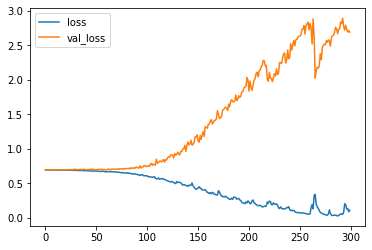

In [60]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

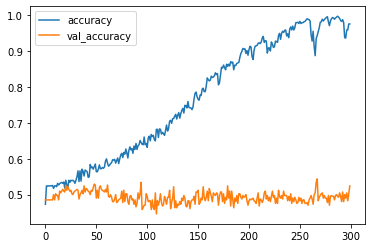

In [61]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [56]:
## For binary classification , the worst accuracy is 50% not 0 %